## EDA

Import Necessary Modules

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import filtering_specific_products, create_document_text, normalize_text, apply_text_normalization, verify_no_emails_in_text, preprocess_complaints, get_text_stats


Load Data

In [2]:
df = pd.read_csv('../data/raw/complaints.csv')


C:\Users\mihret.mekbebe\AppData\Local\Temp\ipykernel_28768\4203144710.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/complaints.csv')


In [3]:
print(f"✓ Loaded {len(df):,} complaints")
print(f"✓ Columns: {len(df.columns)}")

✓ Loaded 9,609,797 complaints
✓ Columns: 18


In [4]:
# Quick look at the data structure
print("=" * 60)
print("COLUMN NAMES AND DATA TYPES")
print("=" * 60)
print(df.dtypes)

COLUMN NAMES AND DATA TYPES
Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object


In [5]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)

# Create a summary DataFrame
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)

# Show only columns with missing values
print("MISSING VALUES SUMMARY")
print("=" * 40)
print(missing_df[missing_df['Missing Count'] > 0])

MISSING VALUES SUMMARY
                              Missing Count  Missing %
Tags                                8981029       93.5
Consumer disputed?                  8841498       92.0
Consumer complaint narrative        6629041       69.0
Company public response             4770207       49.6
Consumer consent provided?          1649561       17.2
Sub-issue                            839522        8.7
Sub-product                          235295        2.4
State                                 54516        0.6
ZIP code                              30228        0.3
Company response to consumer             20        0.0
Issue                                     6        0.0


Number of Complaints based on Product

In [6]:
complaint_by_product = df.groupby('Product')['Complaint ID'].count().sort_values(ascending=False)
print("\nTotal Complaints per Product:")
print(complaint_by_product)


Total Complaints per Product:
Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                          

Visualizing Consumer Complaint Narrative based on Word Count

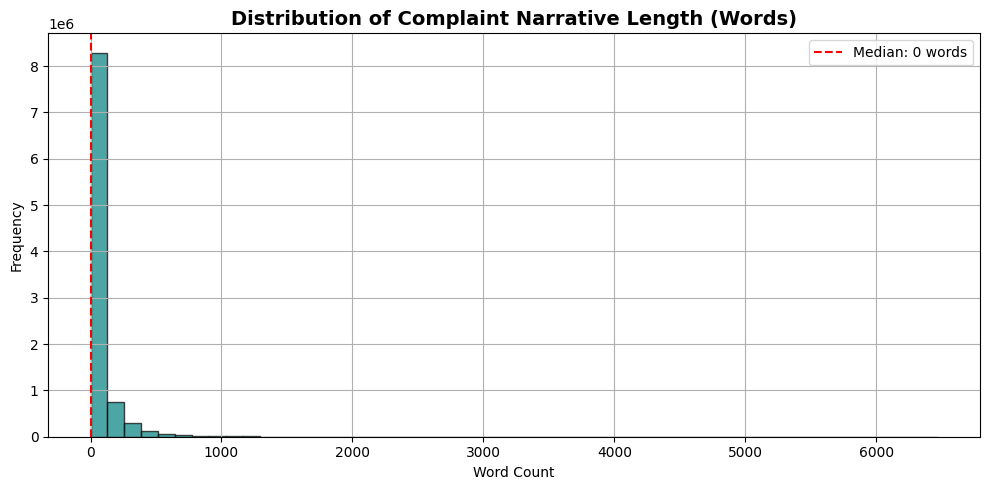


Complaint Narrative Length Statistics (words):
count    9609797.0
mean          54.5
std          149.8
min            0.0
25%            0.0
50%            0.0
75%           50.0
max         6469.0
Name: complaint_word_count, dtype: float64


In [7]:
# Calculate word counts for Complaint Narrative
df['complaint_word_count'] = df['Consumer complaint narrative'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)

# Create histogram
fig, ax = plt.subplots(figsize=(10, 5))
df['complaint_word_count'].hist(bins=50, ax=ax, color='teal', edgecolor='black', alpha=0.7)
ax.set_title('Distribution of Complaint Narrative Length (Words)', fontsize=14, fontweight='bold')
ax.set_xlabel('Word Count')
ax.set_ylabel('Frequency')
ax.axvline(df['complaint_word_count'].median(), color='red', linestyle='--', 
           label=f'Median: {df["complaint_word_count"].median():.0f} words')
ax.legend()
plt.tight_layout()
plt.show()

# Print statistics
print("\nComplaint Narrative Length Statistics (words):")
print(df['complaint_word_count'].describe().round(1))

Given that it shows 0 in minimum and median, it's indicative that null values exist and they are the majorities.

A few missing values on Company response to consumer shows that most companies are responsive, and maybe the missing ones could indicate that the complaints are under review.


Number of Complaints based on existence of Narratives

In [8]:
# Count complaints with narratives (non-null values)
with_narrative = df['Consumer complaint narrative'].count()

# Count complaints without narratives (null values)
without_narrative = df['Consumer complaint narrative'].isnull().sum()

print(f"Complaints with narratives: {with_narrative}")
print(f"Complaints without narratives: {without_narrative}")

Complaints with narratives: 2980756
Complaints without narratives: 6629041


## Preprocessing

In [9]:
filtered_df = filtering_specific_products(df)
complaint_by_product_filtered = filtered_df.groupby('Product')['Complaint ID'].count().sort_values(ascending=False)
print("\nTotal Complaints per Product after filtering:")
print(complaint_by_product_filtered)


Total Complaints per Product after filtering:
Product
Credit card        80667
Money transfers     1497
Name: Complaint ID, dtype: int64


In [10]:
# Create document_text field
df_with_text = create_document_text(filtered_df)

# Show the new column
print("\nNew 'document_text' column created!")
print("This is what will be embedded for RAG.")

✓ Created 'document_text' column

New 'document_text' column created!
This is what will be embedded for RAG.


In [11]:
filtered_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,complaint_word_count
12237,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,Servicemember,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,91
13280,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NY,11220,NaN,Consent provided,Web,2025-06-13,Closed with monetary relief,Yes,NaN,14047085,156
13506,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",IL,60067,NaN,Consent provided,Web,2025-06-12,Closed with explanation,Yes,NaN,14040217,233
13955,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78413,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13968411,454
14249,2025-06-09,Credit card,General-purpose credit card or charge card,Problem when making payments,Problem during payment process,"Although the account had been deemed closed, I...",Company believes it acted appropriately as aut...,Atlanticus Services Corporation,NY,11212,Older American,Consent provided,Web,2025-06-09,Closed with monetary relief,Yes,NaN,13965746,170


In [12]:
# Let's look at a few examples of document_text
print("=" * 70)
print("SAMPLE DOCUMENT TEXTS (what will be embedded)")
print("=" * 70)

for i in range(3):
    print(f"\n--- Example {i+1} (Complaint ID: {df_with_text.iloc[i]['Complaint ID']}) ---")
    print(df_with_text.iloc[i]['document_text'][:500])
    print("..." if len(df_with_text.iloc[i]['document_text']) > 500 else "")

SAMPLE DOCUMENT TEXTS (what will be embedded)

--- Example 1 (Complaint ID: 14069121) ---
Issue: Getting a credit card
Narrative: A XXXX XXXX card was opened under my name by a fraudster. I received a notice from XXXX  that an account was just opened under my name. I reached out to XXXX XXXX to state that this activity was unauthorized and not me. XXXX XXXX confirmed this was fraudulent and immediately closed the card. However, they have failed to remove this from the three credit agencies and this fraud is now impacting my credit score based on a hard credit pull done by XXXX XXXX t
...

--- Example 2 (Complaint ID: 14047085) ---
Issue: Other features, terms, or problems
Narrative: Dear CFPB, I have a secured credit card with citibank which is changed to unsecured card and I have been calling n waitting for the check release the secured amount {$2500.00} for rhat credit card. They told me to wait then today they told me someone cashed my check but their system doesnt have info as of w

In [13]:
# Normalize the text (clean up whitespace, etc.)
df_normalized = apply_text_normalization(df_with_text)

✓ Applied text normalization


In [14]:
# Check for any email addresses in document_text
is_safe = verify_no_emails_in_text(df_normalized)

if is_safe:
    print("\n🎉 SAFETY CHECK PASSED!")
    print("No email addresses found in document_text.")
    print("Data is safe to embed.")
else:
    print("\n⚠️  WARNING: Email addresses found!")
    print("Please review the data before proceeding.")

⚠ WARNING: Found 13 email(s) in 'document_text'!
  Examples: ['XXXX@citi.XXXX', 'support@chime.com', 'citipayments@citi.com']

⚠️  WARNING: Email addresses found!
Please review the data before proceeding.


In [15]:
# Removing those found emails
email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
df_normalized['document_text']=df_normalized['document_text'].str.replace(email_pattern, '', regex=True)

In [16]:
# Recheck for any email addresses in document_text
is_safe = verify_no_emails_in_text(df_normalized)

if is_safe:
    print("\n🎉 SAFETY CHECK PASSED!")
    print("No email addresses found in document_text.")
    print("Data is safe to embed.")
else:
    print("\n⚠️  WARNING: Email addresses found!")
    print("Please review the data before proceeding.")

✓ No emails found in 'document_text' - safe to embed

🎉 SAFETY CHECK PASSED!
No email addresses found in document_text.
Data is safe to embed.


In [17]:
# Run the full preprocessing pipeline
# This combines all steps: drop PII, create document_text, normalize, verify
df_clean = preprocess_complaints(filtered_df)

Starting preprocessing pipeline...
✓ Created 'document_text' column
✓ Applied text normalization
⚠ WARNING: Found 13 email(s) in 'document_text'!
  Examples: ['XXXX@citi.XXXX', 'support@chime.com', 'citipayments@citi.com']
✓ No emails found in 'document_text' - safe to embed
✓ Preprocessing complete. 82,164 complaints processed.


In [18]:
# Get statistics about the document text
text_stats = get_text_stats(df_clean)

print("\nDOCUMENT TEXT STATISTICS")
print("=" * 40)
for key, value in text_stats.items():
    print(f"{key}: {value}")


DOCUMENT TEXT STATISTICS
min_words: 14
max_words: 6487
mean_words: 214.3
median_words: 155
total_documents: 82164
empty_documents: 0


In [19]:
# Saving the filtered dataframe
df_clean.to_csv('../data/processed/filtered_complaints.csv')